# Lab: Cat, Dog Classifier (Binary)

Learn to classify real world images

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/elephantscale/cool-ML-demos/blob/main/image/img3-cat-dog-binary-classifier.ipynb)

### Runtime
~30 minutes

### Note
Here we are dealing with real world images.  Processing them will required a lot of compute power.  
If you have access to, switch to **GPU** as run time!

This is a long lab, with lots of concepts covered.  We encourage you to run this step-by-step and understand each step.

**Instructor** walk through this lab step-by-step and explain

### References
- https://www.tensorflow.org/tutorials/images/classification

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
print ('tensorflow version :', tf.__version__)
tf.config.experimental.list_physical_devices()

tensorflow version : 2.2.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [2]:
## Loading our custom utils files
import os
import sys
from pathlib import Path

# Hack to download image utils when running on Colab ..etc
import os
import urllib.request

file_url = 'https://raw.githubusercontent.com/elephantscale/es-public/master/deep-learning/image_utils.py'
file_location = "image_utils.py"

if not os.path.exists (file_location):
    file_location = os.path.basename(file_location)
    if not os.path.exists(file_location):
        print("Downloading : ", file_url)
        urllib.request.urlretrieve(file_url, file_location)
# print('file_location:', file_location)

## TF-GPU Debug
The following block tests if TF is running on GPU.

In [3]:
## This block is to tweak TF running on GPU
## You may comment this out, if you are not using GPU

## ---- start Memory setting ----
## Ask TF not to allocate all GPU memory at once.. allocate as needed
## Without this the execution will fail with "failed to initialize algorithm" error

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)
## ---- end Memory setting ----

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



## Step 1: Download Data

We have 2 datasets
- cat-dog-redux (smaller) (files: 1000 , size: ~25 MB )
- cat-dog-filtered (larger) (files: 3000,   size:~64 MB)

We will start with the smaller one.  
And once we have the full notebook ready, we can switch to the larger dataset.

In [4]:
# ## Smaller dataset

# import os

# data_location = 'https://elephantscale-public.s3.amazonaws.com/data/images/cat-dog-redux.zip'

# data_location_local = keras.utils.get_file(fname=os.path.basename(data_location),
#                                            origin=data_location, extract=True)
# print ('local download file: ', data_location_local)
# data_dir = os.path.join(os.path.dirname(data_location_local), 'cat-dog-redux')
# print ('local data dir: ', data_dir)
# train_dir = os.path.join(data_dir, 'train')
# validation_dir = os.path.join(data_dir, 'val')
# print ('train dir:', train_dir)
# print ('validation dir:', validation_dir)


In [5]:
## Larget dataset

# TODO-Later:  Try with this larger dataset and see if you get a higher accuracy.

import os
data_location = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
data_location_local = keras.utils.get_file(fname=os.path.basename(data_location),
                                           origin=data_location, extract=True)
print ('local download file: ', data_location_local)

## Peek inside the directory
download_dir = os.path.dirname(data_location_local)
print ("download dir: ", download_dir )

# print a nice tree
! tree -d $download_dir



data_dir = os.path.join(os.path.dirname(data_location_local), 'cats_and_dogs_filtered')
print ('local data dir: ', data_dir)
# peek inside data dir
! tree -d $data_dir

train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
print ('train dir:', train_dir)
print ('validation dir:', validation_dir)


local download file:  /home/sujee/.keras/datasets/cats_and_dogs_filtered.zip
download dir:  /home/sujee/.keras/datasets
/home/sujee/.keras/datasets
├── cat-dog
│   └── data
│       ├── train
│       │   ├── cats
│       │   └── dogs
│       └── validation
│           ├── cats
│           └── dogs
├── cat-dog-redux
│   ├── train
│   │   ├── cat
│   │   └── dog
│   └── val
│       ├── cat
│       └── dog
├── cats_and_dogs_filtered
│   ├── train
│   │   ├── cats
│   │   └── dogs
│   └── validation
│       ├── cats
│       └── dogs
├── cifar-10-batches-py
├── data
│   ├── train
│   │   ├── cat
│   │   └── dog
│   └── val
│       ├── cat
│       └── dog
├── flowers
│   ├── training
│   │   ├── daisy
│   │   ├── dandelion
│   │   ├── roses
│   │   ├── sunflowers
│   │   └── tulips
│   └── validation
│       ├── daisy
│       ├── dandelion
│       ├── roses
│       ├── sunflowers
│       └── tulips
└── horse-or-human
    ├── train
    │   ├── horses
    │   └── humans
    └── validation
     

### See the images and get some stats

Found class lables: ['dogs', 'cats']

--- training_data (/home/sujee/.keras/datasets/cats_and_dogs_filtered/train):  files=2000,  size=43.5 MB
       +-- dogs :  files=1000,  size=23.39 MB
       +-- cats :  files=1000,  size=20.11 MB

--- validation_data (/home/sujee/.keras/datasets/cats_and_dogs_filtered/validation):  files=1000,  size=21.88 MB
       +-- dogs :  files=500,  size=12.06 MB
       +-- cats :  files=500,  size=9.82 MB


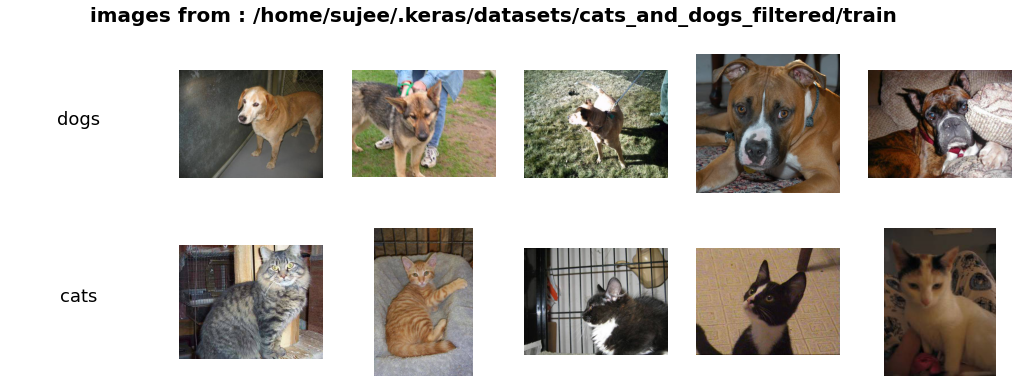

In [6]:
from image_utils import print_training_validation_stats, display_images_from_dir

print_training_validation_stats(train_dir, validation_dir)

## Every time we execute this cell, we will get different images
display_images_from_dir(train_dir)

## Step 2: Define some constants

In [7]:
BATCH_SIZE=128
EPOCHS = 10
IMG_HEIGHT = 150
IMG_WIDTH = 150
APP_NAME = 'cats-and-dogs'

## Step 3: Create Image Data Generators

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Here we are rescaling images by dividing it by 255
## We are shuffling the images to increase randomness
## Images are reshaped to 150x150
## Since we have two images, the class is binary

# train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data

train_image_generator = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=45,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            horizontal_flip=True,
                            shear_range=0.2,
                            zoom_range=0.5,
                            fill_mode='nearest'
                            )


## TODO-Later
## Add a train_image_generator with image augmentation


validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary'
                                                           # class_mode='categorical'
                                                          )


val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary'
                                                              # class_mode='categorical'
                                                             )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Step 4: Create a Model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 18, 64)        0

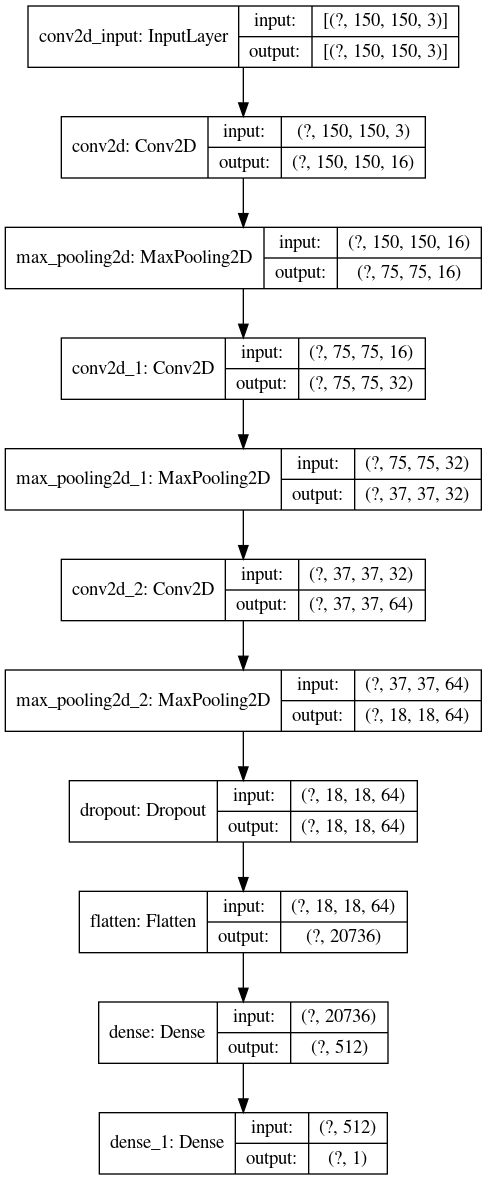

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

NUM_CLASSES = len(train_data_gen.class_indices)

model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D((2,2)),
    #Dropout(0.2),  ## <-- adding dropout
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.5),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
    # Dense(NUM_CLASSES, activation='softmax')
])

print(model.summary())
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

### Compile the model

In [10]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              #loss = 'categorical_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

# model.compile(optimizer='adam',
#               # loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               loss = 'categorical_crossentropy',
#               metrics=['accuracy'])

## Step 5 - Setup Tensorboard

In [11]:
## This is fairly boiler plate code

import datetime
import os
import shutil

app_name = APP_NAME


# timestamp  = datetime.datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

tb_top_level_dir= '/tmp/tensorboard-logs'

tb_app_dir = os.path.join (tb_top_level_dir, app_name)

tb_logs_dir = os.path.join (tb_app_dir, datetime.datetime.now().strftime("%H-%M-%S"))


print ("Saving TB logs to : " , tb_logs_dir)

#clear out old logs
shutil.rmtree ( tb_app_dir, ignore_errors=True )

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_logs_dir, write_graph=True, 
                                                      write_images=True, histogram_freq=1)

## This will embed Tensorboard right here in jupyter!
# ! killall tensorboard  # kill previously running tensorboards
%load_ext tensorboard
%tensorboard --logdir $tb_logs_dir

Saving TB logs to :  /tmp/tensorboard-logs/cats-and-dogs/15-28-24


## Step 6 : Train

In [12]:
%%time 

from math import ceil

history = model.fit(
    train_data_gen,
    steps_per_epoch= train_data_gen.n // train_data_gen.batch_size,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.n // val_data_gen.batch_size,
#     validation_steps=ceil(val_data_gen.n / val_data_gen.batch_size),
    callbacks = [tensorboard_callback]
)

Epoch 1/100
15/15 [==============================] - 10s 676ms/step - loss: 1.1987 - accuracy: 0.5010 - val_loss: 0.6926 - val_accuracy: 0.4955
Epoch 2/100
15/15 [==============================] - 10s 680ms/step - loss: 0.6924 - accuracy: 0.5101 - val_loss: 0.6901 - val_accuracy: 0.5234
Epoch 3/100
15/15 [==============================] - 10s 693ms/step - loss: 0.6916 - accuracy: 0.5144 - val_loss: 0.6815 - val_accuracy: 0.5569
Epoch 4/100
15/15 [==============================] - 10s 693ms/step - loss: 0.6913 - accuracy: 0.5246 - val_loss: 0.6767 - val_accuracy: 0.5960
Epoch 5/100
15/15 [==============================] - 10s 692ms/step - loss: 0.6870 - accuracy: 0.5604 - val_loss: 0.6697 - val_accuracy: 0.5837
Epoch 6/100
15/15 [==============================] - 10s 693ms/step - loss: 0.6852 - accuracy: 0.5705 - val_loss: 0.8043 - val_accuracy: 0.4989
Epoch 7/100
15/15 [==============================] - 10s 680ms/step - loss: 0.6893 - accuracy: 0.5625 - val_loss: 0.6487 - val_accuracy:

### Save the model for reuse later
As you can see training takes a long time.  
Let's save the resulting model, so we can use it quickly without going through training again.

In [13]:
import os

model_file = APP_NAME + '-model.h5'
model.save(model_file)

model_size_in_bytes = os.path.getsize(model_file)
print ("model saved as '{}',  size = {:,} bytes / {:,.1f} KB  / {:,.1f} MB".format(model_file, 
                                    model_size_in_bytes, model_size_in_bytes / 1024, 
                                    model_size_in_bytes / (1024*1024) ))

model saved as 'cats-and-dogs-model.h5',  size = 85,179,984 bytes / 83,183.6 KB  / 81.2 MB


## Step 7 : See Training History

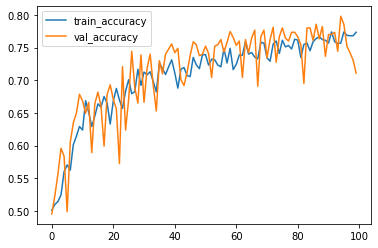

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

## Step 8 : Evaluate the Model 

### 8.1 - Metrics

In [15]:
from math import ceil

metric_names = model.metrics_names
print ("model metrics : " , metric_names)

metrics = model.evaluate(val_data_gen, batch_size=val_data_gen.batch_size, steps=ceil(val_data_gen.n // val_data_gen.batch_size) )

for idx, metric in enumerate(metric_names):
    print ("Metric : {} = {:,.3f}".format (metric_names[idx], metrics[idx]))

model metrics :  ['loss', 'accuracy']
7/7 [==============================] - 1s 186ms/step - loss: 0.5506 - accuracy: 0.7199
Metric : loss = 0.551
Metric : accuracy = 0.720


### 8.2 - Predictions and Confusion Matrix

In [16]:
import numpy as np
from math import ceil


print ("predicting on {:,} test images".format(val_data_gen.n))
# we need a ceiling for steps
predictions = model.predict(val_data_gen, batch_size=val_data_gen.batch_size, 
                            steps=ceil(val_data_gen.n / val_data_gen.batch_size) )
print( 'predictions.shape: ', predictions.shape)

if val_data_gen.class_mode == 'categorical':
    # converting softmax --> classes
    print ("convering softmax --> classes")
    predictions2 = [ np.argmax(p) for p in predictions]

if val_data_gen.class_mode == 'binary':
    # converting sigmoid --> classes
    print ("converting sigmod --> binary")
    predictions2 = [0 if n < 0.5 else 1 for n in predictions]


# ## Ensure all predictions match
assert(len(predictions) == len(predictions2) == len(val_data_gen.classes) )

predicting on 1,000 test images
predictions.shape:  (1000, 1)
converting sigmod --> binary


In [17]:
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})

print ('predictions : ' , predictions[:10])
print ('prediction2: ' , predictions2[:10])

predictions :  [[ 0.46]
 [ 0.98]
 [ 0.32]
 [ 0.49]
 [ 0.16]
 [ 0.21]
 [ 0.90]
 [ 0.99]
 [ 0.46]
 [ 0.10]]
prediction2:  [0, 1, 0, 0, 0, 0, 1, 1, 0, 0]


In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_labels = val_data_gen.classes
cm = confusion_matrix(test_labels, predictions2, labels = range(0, NUM_CLASSES))
cm

array([[150, 350],
       [142, 358]])

class index mapping :  {'cats': 0, 'dogs': 1}


[]

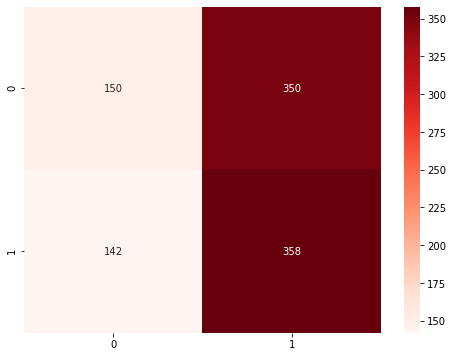

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

print ("class index mapping : ", val_data_gen.class_indices)

plt.figure(figsize = (8,6))

# colormaps : cmap="YlGnBu" , cmap="Greens", cmap="Blues",  cmap="Reds"
sns.heatmap(cm, annot=True, cmap="Reds", fmt='d').plot()

### Overfit
Looking at the learning curves we can see our model is overfitting.  
There are 2 options for us
- Adding Dropout layers
- Using image augmentation


## Step 9 - Adding Dropout

### 9.1 - Modify model

We are going to modify our model by adding Dropout layers.

Replace code in **Step-4** with the following code


```python

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D((2,2)),
    Dropout(0.2),  ## <-- adding dropout
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.2),  ## <-- adding dropout
    Flatten(),
    Dense(512, activation='relu'),
    #Dense(1, activation='sigmoid')
    Dense(NUM_CLASSES, activation='softmax')
])

print(model.summary())
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

```

### 9.2 - Run Again with Dropout layers added

- Select 'Kernel --> Restart Kernel and Run all Cells'
- Notice the training time
- Also observe the learning curve.  Does it look better?
- Do you still detect overfitting?

## Step 10: Adding Image Augmentation

### 10.1 : Modify Training Image Generator

Adding Dropout may have helped a little bit.   
But we still see our model **overfitting** or 'memorizing' training data.  
Let's fix this by introducing small variations to training images.  
This is called **image augmentation**  

In **Step-3** replace **`train_data_generator`** as follows.


```python
train_image_generator = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=45,
                            width_shift_range=.15,
                            height_shift_range=.15,
                            horizontal_flip=True,
                            zoom_range=0.5
                            )
```

### 10.2 - Run Again with Dropout layers + Image Augmentation added

- Select 'Kernel --> Restart Kernel and Run all Cells'
- Notice the training time
- Also observe the learning curve.  Does it look better?
- Do you still detect overfitting?

## Step 11 : Exercise: Evaluate and Improve the Model
See visualizations below!

**TODO: Increase model accuracy (experiment with following approaches)**  
- Switch to a larger dataset in **Step-1**
- Increase the training epochs to 50, 100  in **Step-2**
- Add more layers to the model (you can add Conv+MaxPool layers) and experiment **Step-4**

## Cleanup 
Before running the next exercise, run the following cell to terminate processes and free up resources

In [20]:
## Kill any child processes (like tensorboard)

import psutil
import os, signal

current_process = psutil.Process()
children = current_process.children(recursive=True)
for child in children:
    print('Killing Child pid  {}'.format(child.pid))
    os.kill(child.pid, signal.SIGKILL)
    
## This will kill actual kernel itself
# os.kill(os.getpid(), signal.SIGKILL)

Killing Child pid  22805
